# Master (Leave-One-Out) Pipeline

This is our master pipeline, which takes us through text pre-processing, LDA topic modeling, leave-one-out cross-validation, and model evaluation.

Our analysis focused on comparing three models:
- a model with baseline measures
- a model with baseline measures and topic distributions
- a model with baseline measures and physician's advice

We want to show that the model with topic distributions performs:
1. better than the baseline model
2. comparably to the model with advice

## Import Statements

In [1]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter, defaultdict
from IPython.display import clear_output
from matplotlib import pyplot

import warnings
warnings.filterwarnings('ignore')

#gensim for topic modeling with LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel
from gensim.models import NormModel

#spacy for lemmatization
import spacy
import en_core_web_sm

#xgboost for our classification model
from xgboost import XGBClassifier, plot_importance

#sklearn from cross-validation methods
from sklearn.preprocessing import OneHotEncoder, scale, LabelEncoder
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samanthagarland/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Methods

In [2]:
#for pre-processing our transcripts
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopWords] for doc in texts]

def make_bigrams_dvd(texts):
    return [bigram_mod_dvd[doc] for doc in texts]

def make_trigrams_dvd(texts):
    return [trigram_mod_dvd[bigram_mod_dvd[doc]] for doc in texts]

def make_bigrams_va(texts):
    return [bigram_mod_va[doc] for doc in texts]

def make_trigrams_dvd(texts):
    return [trigram_mod_va[bigram_mod_va[doc]] for doc in texts]

nlp = en_core_web_sm.load(disable=['parser', 'ner'])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out   

In [3]:
#methods for classification methods
def predict_loo(clf, X_train, y_train, X_test, y_test):
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    clf.fit(X_train, y_train.ravel())
    y_pred_tr = clf.predict(X_train)
    y_pred_ts = clf.predict(X_test)
    return y_pred_tr, y_pred_ts

def compute_metrics(actual, pred):
    accuracy = metrics.accuracy_score(actual, pred)
    precision = metrics.precision_score(actual, pred)
    recall = metrics.recall_score(actual, pred)
    auc = metrics.roc_auc_score(actual, pred)
    return accuracy, precision, recall, auc

## Stop Words
For an explanation of how we created this list, please see our Stop_Word_Rules file.

In [4]:
stopWords = stopwords.words('english')
stopWords = set([word.replace("'", "") for word in stopWords])
stopWords = stopWords.union(set(["taiwan", "taiwanese", "communist", "mmmhmm", "'", "'cause", "'em", 'a', 'aa', 'aaah', 'aah', 'ab', 'about', 'above', 'african', 'after', 'again', 'against', 'ah', 'ahh', 'ahhh', 'ahhhh', 'ahhm', 'ain', 'aint', 'alabama', 'alaska', 'all', 'alot', 'alright', 'alrighty', 'also', 'am', 'an', 'anand', 'and', 'andand', 'any', 'anyone', 'are', 'aren', 'arent', 'as', 'at', 'ay', 'b', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'bye', 'c', 'california', 'came', 'can', 'cant', 'clean', 'costa_rica', 'could', 'couldn', 'couldnt', 'cuz', 'd', 'de', 'did', 'didn', 'didnt', 'do', 'doc', 'does', 'doesn', 'doesnt', 'doin', 'doing', 'dokey', 'don', 'dont', 'down', 'during', 'e', 'each', 'eek', 'eh', 'em', 'er', 'et', 'etc', 'europe', 'f', 'few', 'florida','for', 'from', 'further', 'g', 'ga', 'gal', 'gee', 'geez', 'germany', 'get', 'go', 'goin', 'going', 'gonna', 'gosh', 'got', 'gotta', 'greek', 'gu', 'h', 'ha', 'had', 'hadn', 'hadnt', 'has', 'hasn', 'hasnt', 'have', 'haven', 'havent', 'having', 'he', 'hed', 'heh', 'hell', 'hello', 'henry', 'her', 'here', 'hers', 'herself', 'hes', 'hey', 'hi', 'him', 'himself', 'his', 'hm', 'hmm', 'hmmm', 'hodgkins', 'how', 'hows', 'huh', 'hum', 'i', 'id', 'if', 'ifif', 'ii', 'iii', 'ill', 'im', 'imrt', 'in', 'inaudible', 'indecipherable', 'indianapolis', 'into', 'is', 'isis', 'isn', 'isnt', 'it', 'itd', 'itit', 'itll', 'its', 'itself', 'ive', 'j', 'jeez', 'just', 'k', 'kay', 'kinda', 'l', 'laughs', 'le', 'leastno', 'legend', 'let', 'lets', 'like', 'll', 'look', 'lot', 'm', 'ma', 'maam', 'md', 'mdmd', 'me', 'mhm', 'mhmm', 'mhmmm', 'michigan', 'mightn', 'mightnt', 'mightve', 'mkay', 'mm', 'mmhm', 'mmhmm', 'mmkay', 'mmm', 'mmmhmm','mmmhmmm', 'mmmm', 'mmmmm', 'more', 'most', 'mustn', 'mustnt', 'mustve', 'my', 'myself', 'n', 'na', 'nah', 'nahuh', 'nd', 'ne', 'needn', 'neednt', 'nn', 'no', 'nooh', 'noooo', 'nope', 'nor', 'not', 'now', 'o', 'of', 'off', 'oh', 'ohh', 'ohhh', 'ohhhohohohoh', 'ohio', 'ok', 'okay', 'okey', 'on', 'once', 'only', 'oooh', 'or', 'oth', 'other', 'othumhmm', 'oughta', 'our', 'ours', 'ourselves', 'out', 'over', 'ow', 'own', 'p', 'patient', 'phi', 'physician', 'potter', 'pt', 'pt/so', 'q', 'r', 'rd', 're', 'right', 'ro', 's', 'said', 'same', 'say', 'see', 'shan', 'shant', 'she', 'shell', 'shes', 'should', 'shouldn', 'shouldnt', 'shouldve', 'so', 'some', 'sorta', 'sounds', 'st', 'stuff', 'such', 'swedish', 't', 'th', 'than', 'that', 'thatd', 'thatll', 'thats', 'thatsthat', 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'thered', 'thereof', 'theres', 'thereve', 'these', 'thethe', 'thew', 'they', 'theyll', 'theyre', 'theyve', 'thing', 'things', 'this', 'those', 'through', 'ti', 'to', 'too', 'tthe', 'u', 'uh', 'uhh', 'uhhhhh', 'uhhm', 'uhhmm', 'uhhuh', 'uhm', 'uhmhmm', 'uhmhmmm', 'uhmmm', 'uhoh', 'uhum', 'um', 'umhmm', 'umhmmm', 'umm', 'ummm', 'ummmm', 'un', 'under', 'unhunh', 'until', 'up', 'us', 'uuh', 'v', 've', 'very', 'vietnam', 'virginia', 'w', 'walsh', 'wanna', 'was', 'washington', 'wasn', 'wasnt', 'we', 'wed', 'well', 'went', 'were', 'weren', 'werent', 'weve', 'wewe', 'what', 'whatd', 'whatev', 'whatever', 'whatnot', 'whats', 'when', 'where', 'wheres', 'whew', 'which', 'while', 'who', 'whoa', 'whom', 'whos', 'why', 'will', 'with', 'won', 'wont', 'would', 'wouldn', 'wouldnt', 'x', 'y', 'ya', 'yada', 'yah', 'yall', 'yea', 'yeah', 'yep', 'yepvery', 'yer', 'yeyeah', 'you', 'youd', 'youl', 'youll', 'your', 'youre', 'yours', 'yourself', 'yourselves', 'youve', 'youyou', 'yup', 'z']))
print("We have", len(stopWords), "stop words.")

We have 432 stop words.


# Evaluating Our Models

We use accuracy, precision, recall, and AUC as our performance metrics.

## Baseline + Topics

Variables:
- age
- gleason -- cancer grade
- DVD -- control condition from previous study
- tx2_binary -- preference (active surveillance vs treatment) before clinical appointment
- combined_convos -- transcripts from all clinical appointments
- as1 -- physician's advice for active surveillance
- sur1 -- physician's advice for surgery
- rad1 -- physician's advice for radiation therapy

In [5]:
df = pd.read_csv('dvd_advice_text.csv')

factors_all = ["age", "gleason", "DVD", "tx2_binary", "combined_convos", "as1", "sur1", "rad1"]
df = df.dropna(subset=factors_all) #we only want to perform analysis on patients without any missing data for any of our variables

factors_sub = ["age", "gleason", "DVD", "tx2_binary", "combined_convos"] #these are the variables we'll actually use for this model

lda_models = [] #keeps track of all lda models we produce

X = df[factors_sub]
y = df["txgot_binary"]
X = np.array(X)
y = np.array(y)

In [6]:
#how many patients do we have left?
len(X)

139

### Processing the Transcripts

In [7]:
#collect all conversations
convo_dvd = df["combined_convos"]

data_words_dvd = list(sent_to_words(convo_dvd))

#creates bigrams of words commonly found together
#for example, active_surveillance
bigram_dvd = gensim.models.Phrases(data_words_dvd, min_count=2, threshold=100) 

bigram_mod_dvd = gensim.models.phrases.Phraser(bigram_dvd)

#remove stop words
data_words_nostops_dvd = remove_stopwords(data_words_dvd)
data_words_bigrams_dvd = make_bigrams_dvd(data_words_nostops_dvd)

nlp = spacy.load('en', disable=['parser', 'ner'])

#lemmatize the words
data_lemmatized_dvd = lemmatization(data_words_bigrams_dvd, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#remove stop words again (as lemmatization sometimes reduces words that turn out to be stop words)
data_lemmatized_dvd = [[word for word in convo if word not in stopWords] for convo in data_lemmatized_dvd]

### LOOCV Pipeline

In [10]:
#stores the testing predictions and training performance metrics
predictions_ts = []
accuracy_tr = []
precision_tr = []
recall_tr = []
auc_tr = []

# PARAMETERS
#gradient-boosting
max_depth = 3
subsample = 0.9

#LDA
no_below = 0.1 #filters out words that are in fewer than no_below documents
no_above = 0.7 #filters out words that are in more than no_above documents
keep_n = 5000 #dictionary size

loo = LeaveOneOut()
index = 1 # for keeping track of progress

for train_index, test_index in loo.split(X): # Loop over all split possibilities
    #first split up the dataset
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create Bag of words model
    texts_lemmatized = np.array(data_lemmatized_dvd)
    id2word_dvd = corpora.Dictionary(texts_lemmatized[train_index]) # build corpus on training data only (NO LEAKAGE)
    id2word_dvd.filter_extremes(no_below = no_below, no_above = no_above, keep_n = keep_n, keep_tokens = None)

    corp_dvd = [id2word_dvd.doc2bow(text) for text in texts_lemmatized]
    corp_dvd = np.array(corp_dvd)

    # Split corpus by training and testing
    corp_dvd_train = corp_dvd[train_index]
    corp_dvd_test = corp_dvd[test_index]

    # Create LDA Model
    lda_model_dvd = gensim.models.ldamodel.LdaModel(corpus=corp_dvd_train,
                                           id2word=id2word_dvd,
                                           num_topics=12, 
                                           random_state=100,
                                           update_every=3,
                                           chunksize=20,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    lda_models.append(lda_model_dvd)
    
    #convert testing and training to dataframe so we can append distributions
    X_train = pd.DataFrame({'age':X_train[:,0],'gleason':X_train[:,1], "DVD": X_train[:,2], "tx2_binary": X_train[:, 3], 'combined_convos': X_train[:, 4]})
    X_test = pd.DataFrame({'age':X_test[:,0],'gleason':X_test[:,1],"DVD": X_test[:,2], "tx2_binary": X_test[:, 3], 'combined_convos': X_test[:, 4]})

    # get training distributions
    distributions = lda_model_dvd[corp_dvd_train]
    dvd_length = len(corp_dvd_train) 
    topic0 = [0] * dvd_length
    topic1 = [0] * dvd_length
    topic2 = [0] * dvd_length
    topic3 = [0] * dvd_length
    topic4 = [0] * dvd_length
    topic5 = [0] * dvd_length
    topic6 = [0] * dvd_length
    topic7 = [0] * dvd_length
    topic8 = [0] * dvd_length
    topic9 = [0] * dvd_length
    topic10 = [0] * dvd_length
    topic11 = [0] * dvd_length
    
    # store the topic percentage values for training
    for en, row in enumerate(distributions):
        topics = row[0]
        for topic in topics:
            if topic[0] == 0:
                topic0[en] = topic[1]
            elif topic[0] == 1:
                topic1[en] = topic[1]
            elif topic[0] == 2:
                topic2[en] = topic[1]
            elif topic[0] == 3:
                topic3[en] = topic[1]
            elif topic[0] == 4:
                topic4[en] = topic[1]
            elif topic[0] == 5:
                topic5[en] = topic[1]
            elif topic[0] == 6:
                topic6[en] = topic[1]
            elif topic[0] == 7:
                topic7[en] = topic[1]
            elif topic[0] == 8:
                topic8[en] = topic[1]
            elif topic[0] == 9:
                topic9[en] = topic[1]
            elif topic[0] == 10:
                topic10[en] = topic[1]
            elif topic[0] == 11:
                topic11[en] = topic[1]
    X_train['topic0'] = topic0
    X_train['topic1'] = topic1
    X_train['topic2'] = topic2
    X_train['topic3'] = topic3
    X_train['topic4'] = topic4
    X_train['topic5'] = topic5
    X_train['topic6'] = topic6
    X_train['topic7'] = topic7
    X_train['topic8'] = topic8
    X_train['topic9'] = topic9
    X_train['topic10'] = topic10
    X_train['topic11'] = topic11

    # get testing distributions
    distributions = lda_model_dvd[corp_dvd_test]
    dvd_length = len(corp_dvd_test) 
    topic0 = [0] * dvd_length
    topic1 = [0] * dvd_length
    topic2 = [0] * dvd_length
    topic3 = [0] * dvd_length
    topic4 = [0] * dvd_length
    topic5 = [0] * dvd_length
    topic6 = [0] * dvd_length
    topic7 = [0] * dvd_length
    topic8 = [0] * dvd_length
    topic9 = [0] * dvd_length
    topic10 = [0] * dvd_length
    topic11 = [0] * dvd_length
    
    # store the topic percentage values for testing
    for en, row in enumerate(distributions):
        topics = row[0]
        for topic in topics:
            if topic[0] == 0:
                topic0[en] = topic[1]
            elif topic[0] == 1:
                topic1[en] = topic[1]
            elif topic[0] == 2:
                topic2[en] = topic[1]
            elif topic[0] == 3:
                topic3[en] = topic[1]
            elif topic[0] == 4:
                topic4[en] = topic[1]
            elif topic[0] == 5:
                topic5[en] = topic[1]
            elif topic[0] == 6:
                topic6[en] = topic[1]
            elif topic[0] == 7:
                topic7[en] = topic[1]
            elif topic[0] == 8:
                topic8[en] = topic[1]
            elif topic[0] == 9:
                topic9[en] = topic[1]
            elif topic[0] == 10:
                topic10[en] = topic[1]
            elif topic[0] == 11:
                topic11[en] = topic[1]
    X_test['topic0'] = topic0
    X_test['topic1'] = topic1
    X_test['topic2'] = topic2
    X_test['topic3'] = topic3
    X_test['topic4'] = topic4
    X_test['topic5'] = topic5
    X_test['topic6'] = topic6
    X_test['topic7'] = topic7
    X_test['topic8'] = topic8
    X_test['topic9'] = topic9
    X_test['topic10'] = topic10
    X_test['topic11'] = topic11

    #take out combined_convos column so we don't feel raw text to algorithm
    X_train = X_train[["age", "gleason", "DVD", "tx2_binary", "topic0", "topic1", "topic2", "topic3", "topic4", "topic5", "topic6", "topic7", "topic8", "topic9", "topic10", "topic11"]]
    X_test = X_test[["age", "gleason", "DVD", "tx2_binary", "topic0", "topic1", "topic2", "topic3", "topic4", "topic5", "topic6", "topic7", "topic8", "topic9", "topic10", "topic11"]]
 
    # fit model and predict
    xgb = XGBClassifier(max_depth = max_depth, subsample = subsample)
    y_pred_tr, y_pred_ts = predict_loo(xgb, X_train, y_train, X_test, y_test)
    predictions_ts.append(y_pred_ts) #save prediction from each run-through
    
    # compute and store training performance
    acc, prec, rec, auc = compute_metrics(y_train, y_pred_tr)
    accuracy_tr.append(acc)
    precision_tr.append(prec)
    recall_tr.append(rec)
    auc_tr.append(auc)
    
    clear_output(wait=True)
    print('finished round ', index)
    index += 1

finished round  139


In [11]:
# training performance
print('training accuracy: ', np.average(accuracy_tr))
print('training precision: ', np.average(precision_tr))
print('training recall: ', np.average(recall_tr))
print('training auc: ', np.average(auc_tr))

print()

# testing performance
accuracy, precision, recall, auc = compute_metrics(y, predictions_ts)
print('testing accuracy: ', accuracy)
print('testing precision: ', precision)
print('testing recall: ', recall)
print('testing auc ', auc)

training accuracy:  0.9874882702533626
training precision:  0.99332800356365
training recall:  0.9553020685056233
training auc:  0.9766153792603222

testing accuracy:  0.7841726618705036
testing precision:  0.5833333333333334
testing recall:  0.4117647058823529
testing auc  0.6582633053221288


# Baseline

Variables:
- age
- gleason -- cancer grade
- DVD -- control condition from previous study
- tx2_binary -- preference (active surveillance vs treatment) before clinical appointment

In [12]:
#stores the testing predictions and training performance metrics
predictions_ts = []
accuracy_tr = []
precision_tr = []
recall_tr = []
auc_tr = []

# Define parameters for gradient-boosting algorithm
max_depth = 3
subsample = 0.9

X = df[["age", "gleason", "DVD", "tx2_binary"]]
y = df["txgot_binary"]
X = np.array(X)
y = np.array(y)

loo = LeaveOneOut()

index = 1 # for keeping track of progress

for train_index, test_index in loo.split(X): # Loop over all split possibilities
    #first split up the dataset
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # fit model and predict
    xgb = XGBClassifier(max_depth = max_depth, subsample = subsample)
    y_pred_tr, y_pred_ts = predict_loo(xgb, X_train, y_train, X_test, y_test)
    predictions_ts.append(y_pred_ts)
    
    # compute and store training performance
    acc, prec, rec, auc = compute_metrics(y_train, y_pred_tr)
    accuracy_tr.append(acc)
    precision_tr.append(prec)
    recall_tr.append(rec)
    auc_tr.append(auc)
    
    clear_output(wait=True)
    print('finished round ', index)
    index += 1

finished round  139


In [13]:
# training performance
print('training accuracy: ', np.average(accuracy_tr))
print('training precision: ', np.average(precision_tr))
print('training recall: ', np.average(recall_tr))
print('training auc: ', np.average(auc_tr))

print()

# testing performance
accuracy, precision, recall, auc = compute_metrics(y, predictions_ts)
print('testing accuracy: ', accuracy)
print('testing precision: ', precision)
print('testing recall: ', recall)
print('testing auc ', auc)

training accuracy:  0.8702950682931916
training precision:  0.8404059000117805
training recall:  0.5803229074494415
training auc:  0.7722509469652932

testing accuracy:  0.7553956834532374
testing precision:  0.5
testing recall:  0.38235294117647056
testing auc  0.6292717086834734


# Baseline and Advice

Variables:
- age
- gleason -- cancer grade
- DVD -- control condition from previous study
- tx2_binary -- preference (active surveillance vs treatment) before clinical appointment
- as1 -- physician's advice for active surveillance
- sur1 -- physician's advice for surgery
- rad1 -- physician's advice for radiation therapy

In [14]:
#stores the testing predictions and training performance metrics
predictions_ts = []
accuracy_tr = []
precision_tr = []
recall_tr = []
auc_tr = []

# Define parameters for xgboost
max_depth = 3
subsample = 0.9

X = df[["age", "gleason", "DVD", "tx2_binary", "as1", "sur1", "rad1"]]
y = df["txgot_binary"]
X = np.array(X)
y = np.array(y)

loo = LeaveOneOut()

index = 1 # for keeping track of progress

for train_index, test_index in loo.split(X): # Loop over all split possibilities
    #first split up the dataset
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # fit model and predict
    xgb = XGBClassifier(max_depth = max_depth, subsample = subsample)
    y_pred_tr, y_pred_ts = predict_loo(xgb, X_train, y_train, X_test, y_test)
    predictions_ts.append(y_pred_ts)
    
    # compute and store training performance
    acc, prec, rec, auc = compute_metrics(y_train, y_pred_tr)
    accuracy_tr.append(acc)
    precision_tr.append(prec)
    recall_tr.append(rec)
    auc_tr.append(auc)
    
    clear_output(wait=True)
    print('finished round ', index)
    index += 1

finished round  139


In [15]:
# training performance
print('training accuracy: ', np.average(accuracy_tr))
print('training precision: ', np.average(precision_tr))
print('training recall: ', np.average(recall_tr))
print('training auc: ', np.average(auc_tr))

print()

# testing performance
accuracy, precision, recall, auc = compute_metrics(y, predictions_ts)
print('testing accuracy: ', accuracy)
print('testing precision: ', precision)
print('testing recall: ', recall)
print('testing auc ', auc)

training accuracy:  0.9393181107288082
training precision:  0.8825104214664199
training recall:  0.8680413957603971
training auc:  0.9152109105452314

testing accuracy:  0.7769784172661871
testing precision:  0.5517241379310345
testing recall:  0.47058823529411764
testing auc  0.673389355742297


# Compute Feature Importances

After using the metrics from above to determine that the parameters we set lead to good accuracy and AUC, we run this on the entire corpus of transcripts to create our master model. From this model, we calculate the feature importances of the variables.

In [16]:
df = pd.read_csv('dvd_withAdvice_final.csv')

# Subset the dataframe
factors_all = ["age", "gleason", "DVD", "tx2_binary", "combined_convos", "as1", "sur1", "rad1"]
factors_sub = ["age", "gleason", "DVD", "tx2_binary", "combined_convos"]

df = df.dropna(subset=factors_all)

X = df[factors_sub]
y = df["txgot_binary"]
X = np.array(X)
y = np.array(y)

#use all the transcripts
convo_dvd = df["combined_convos"]
data_words_dvd = list(sent_to_words(convo_dvd))

#creates bigrams of words commonly found together
#for example, active_surveillance
bigram_dvd = gensim.models.Phrases(data_words_dvd, min_count=2, threshold=100) 
bigram_mod_dvd = gensim.models.phrases.Phraser(bigram_dvd)

#remove all stop words
data_words_nostops_dvd = remove_stopwords(data_words_dvd)
data_words_bigrams_dvd = make_bigrams_dvd(data_words_nostops_dvd)

nlp = spacy.load('en', disable=['parser', 'ner'])

#lemmatize the data, and perform another round of removing stopwords
data_lemmatized_dvd = lemmatization(data_words_bigrams_dvd, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized_dvd = [[word for word in convo if word not in stopWords] for convo in data_lemmatized_dvd]

In [17]:
#PARAMETERS:

#xgboost
max_depth = 3
subsample = 0.9

#LDA
no_below = 0.1
no_above = 0.7
keep_n = 5000

# Build Corpus
texts_lemmatized = np.array(data_lemmatized_dvd)
id2word_dvd = corpora.Dictionary(texts_lemmatized) # build corpus on entire dataset
id2word_dvd.filter_extremes(no_below = no_below, no_above = no_above, keep_n = keep_n, keep_tokens = None)
corp_dvd = [id2word_dvd.doc2bow(text) for text in texts_lemmatized]
corp_dvd = np.array(corp_dvd)

# Create LDA Model with corpus from above
lda_model_dvd = gensim.models.ldamodel.LdaModel(corpus=corp_dvd,
                                       id2word=id2word_dvd,
                                       num_topics=12, 
                                       random_state=100,
                                       update_every=3,
                                       chunksize=20,
                                       passes=10,
                                       alpha='auto',
                                       per_word_topics=True)

#revert X back to dataframe so we can add on the topic distributions
X = pd.DataFrame({'age':X[:,0],'gleason':X[:,1], "DVD": X[:,2], "tx2_binary": X[:, 3], 'combined_convos': X[:, 4]})

# Get topic distributions for entire dataset
distributions = lda_model_dvd[corp_dvd]
dvd_length = len(corp_dvd) 
topic0 = [0] * dvd_length
topic1 = [0] * dvd_length
topic2 = [0] * dvd_length
topic3 = [0] * dvd_length
topic4 = [0] * dvd_length
topic5 = [0] * dvd_length
topic6 = [0] * dvd_length
topic7 = [0] * dvd_length
topic8 = [0] * dvd_length
topic9 = [0] * dvd_length
topic10 = [0] * dvd_length
topic11 = [0] * dvd_length

# Store the topic percentage values
for en, row in enumerate(distributions):
    topics = row[0]
    for topic in topics:
        if topic[0] == 0:
            topic0[en] = topic[1]
        elif topic[0] == 1:
            topic1[en] = topic[1]
        elif topic[0] == 2:
            topic2[en] = topic[1]
        elif topic[0] == 3:
            topic3[en] = topic[1]
        elif topic[0] == 4:
            topic4[en] = topic[1]
        elif topic[0] == 5:
            topic5[en] = topic[1]
        elif topic[0] == 6:
            topic6[en] = topic[1]
        elif topic[0] == 7:
            topic7[en] = topic[1]
        elif topic[0] == 8:
            topic8[en] = topic[1]
        elif topic[0] == 9:
            topic9[en] = topic[1]
        elif topic[0] == 10:
            topic10[en] = topic[1]
        elif topic[0] == 11:
            topic11[en] = topic[1]

# Create new columns in dataframe with topic distributions
X['topic0'] = topic0
X['topic1'] = topic1
X['topic2'] = topic2
X['topic3'] = topic3
X['topic4'] = topic4
X['topic5'] = topic5
X['topic6'] = topic6
X['topic7'] = topic7
X['topic8'] = topic8
X['topic9'] = topic9
X['topic10'] = topic10
X['topic11'] = topic11

# Subset dataframe for model training (this removed combined_convos, so we don't feed the algorithm raw text) 
X = X[["age", "gleason", "tx2_binary", "DVD", "topic0", "topic1", "topic2", "topic3", "topic4", "topic5", "topic6", "topic7", "topic8", "topic9", "topic10", "topic11"]]

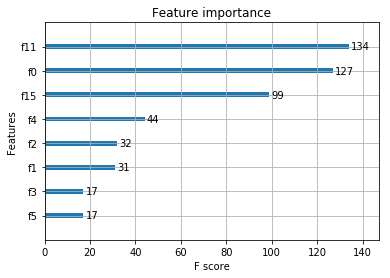

['topic7', 0.26746505]
['age', 0.253493]
['topic11', 0.19760479]
['topic0', 0.08782435]
['tx2_binary', 0.063872255]
['gleason', 0.06187625]
['topic1', 0.033932135]
['DVD', 0.033932135]
['topic10', 0.0]
['topic9', 0.0]
['topic8', 0.0]
['topic6', 0.0]
['topic5', 0.0]
['topic4', 0.0]
['topic3', 0.0]
['topic2', 0.0]


In [18]:
#create our model
clf = XGBClassifier(max_depth = max_depth, subsample = subsample)
X_np = np.array(X)
clf.fit(X_np, y)

#plots the feature importances
temp = plot_importance(clf)
pyplot.show(temp)

#lists the features in order of importance
sorted_idx = np.argsort(clf.feature_importances_)[::-1]
for index in sorted_idx:
    print([X.columns[index], clf.feature_importances_[index]]) 

# Visualizing the Topics

In [19]:
#print the top words used to form each topic
print("DVD Topics:")
pprint(lda_model_dvd.print_topics(num_words=50))

DVD Topics:
[(0,
  '0.011*"robotic" + 0.011*"erectile" + 0.009*"heal" + 0.008*"robot" + '
  '0.007*"pill" + 0.007*"small_incision" + 0.006*"situation" + 0.006*"book" + '
  '0.006*"lymph_node" + 0.006*"spare" + 0.006*"dry" + 0.006*"fix" + '
  '0.006*"generally" + 0.006*"pad" + 0.005*"anywhere" + 0.005*"list" + '
  '0.005*"outside" + 0.005*"rare" + 0.005*"trip" + 0.005*"pathology" + '
  '0.004*"soon" + 0.004*"volume" + 0.004*"physical" + 0.004*"damage" + '
  '0.004*"sew" + 0.004*"activity" + 0.004*"orgasm" + 0.004*"wear" + '
  '0.004*"recover" + 0.004*"ability" + 0.004*"exercise" + 0.004*"room" + '
  '0.004*"percent" + 0.004*"necessarily" + 0.004*"fluid" + 0.004*"penis" + '
  '0.004*"hold" + 0.003*"rate" + 0.003*"almost_dry" + 0.003*"confine" + '
  '0.003*"undetectable" + 0.003*"nurse" + 0.003*"bowel" + 0.003*"wood" + '
  '0.003*"notice" + 0.003*"regain" + 0.003*"additional" + 0.003*"viagra" + '
  '0.003*"active" + 0.003*"around"'),
 (1,
  '0.053*"mmhmmm" + 0.018*"righty" + 0.008*"brothe

In [21]:
#visualize the master LDA model
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis_dvd = pyLDAvis.gensim.prepare(lda_model_dvd, corp_dvd, id2word_dvd)
vis_dvd

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      72.718880        1       1 -0.098775 -0.026006
11     22.385555        1       2 -0.141966 -0.089041
0       3.762426        1       3 -0.295192  0.086814
1       1.030274        1       4  0.011040 -0.156442
9       0.082854        1       5  0.065363  0.034222
10      0.015936        1       6  0.070989  0.026434
4       0.000696        1       7  0.064704  0.020637
8       0.000694        1       8  0.064654  0.020607
5       0.000690        1       9  0.064726  0.020659
2       0.000667        1      10  0.064808  0.020702
6       0.000667        1      11  0.064817  0.020699
3       0.000665        1      12  0.064832  0.020715, topic_info=     Category        Freq              Term       Total  loglift  logprob
term                                                                     
482   Default  542.000000             bowel  542.000000  30.0000  30.0000
612   Default  576.000000           implant  576.000000  29.0000  29.0000
562   Default  753.000000     external_beam  753.000000  28.0000  28.0000
486   Default  456.000000     brachytherapy  456.000000  27.0000  27.0000
631   Default  324.000000        irritation  324.000000  26.0000  26.0000
17    Default  352.000000          approach  352.000000  25.0000  25.0000
489   Default  210.000000           brother  210.000000  24.0000  24.0000
1976  Default  304.000000    clinical_trial  304.000000  23.0000  23.0000
536   Default  327.000000           deliver  327.000000  22.0000  22.0000
978   Default  332.000000          erectile  332.000000  21.0000  21.0000
195   Default  261.000000            rectal  261.000000  20.0000  20.0000
209   Default  324.000000           robotic  324.000000  19.0000  19.0000
127   Default  271.000000              line  271.000000  18.0000  18.0000
56    Default  281.000000           ct_scan  281.000000  17.0000  17.0000
1950  Default  379.000000              beam  379.000000  16.0000  16.0000
1796  Default  277.000000      testosterone  277.000000  15.0000  15.0000
623   Default  227.000000          instance  227.000000  14.0000  14.0000
595   Default  529.000000             group  529.000000  13.0000  13.0000
472   Default  244.000000            beacon  244.000000  12.0000  12.0000
561   Default  373.000000          external  373.000000  11.0000  11.0000
133   Default  297.000000        lymph_node  297.000000  10.0000  10.0000
641   Default  259.000000            listen  259.000000   9.0000   9.0000
879   Default  228.000000    blood_pressure  228.000000   8.0000   8.0000
333   Default  232.000000            family  232.000000   7.0000   7.0000
664   Default  411.000000            needle  411.000000   6.0000   6.0000
1028  Default  316.000000   hormone_therapy  316.000000   5.0000   5.0000
632   Default  192.000000               kid  192.000000   4.0000   4.0000
538   Default  205.000000        department  205.000000   3.0000   3.0000
2070  Default  168.000000  hormonal_therapy  168.000000   2.0000   2.0000
566   Default  206.000000           fatigue  206.000000   1.0000   1.0000
...       ...         ...               ...         ...      ...      ...
612   Topic12    0.000209           implant  576.595215  -2.9078  -8.5018
595   Topic12    0.000209             group  529.832092  -2.8239  -8.5025
482   Topic12    0.000209             bowel  542.408142  -2.8486  -8.5037
562   Topic12    0.000209     external_beam  753.690552  -3.1784  -8.5045
133   Topic12    0.000209        lymph_node  297.099945  -2.2487  -8.5058
190   Topic12    0.000208              rate  256.136292  -2.1010  -8.5064
227   Topic12    0.000208         situation  239.077179  -2.0324  -8.5067
561   Topic12    0.000208          external  373.130157  -2.4780  -8.5072
909   Topic12    0.000208            choose  355.690308  -2.4307  -8.5078
26    Topic12    0.000208           benefit  353.917755  -2.4257  -8.5078
664   Topic12    0.